<div>
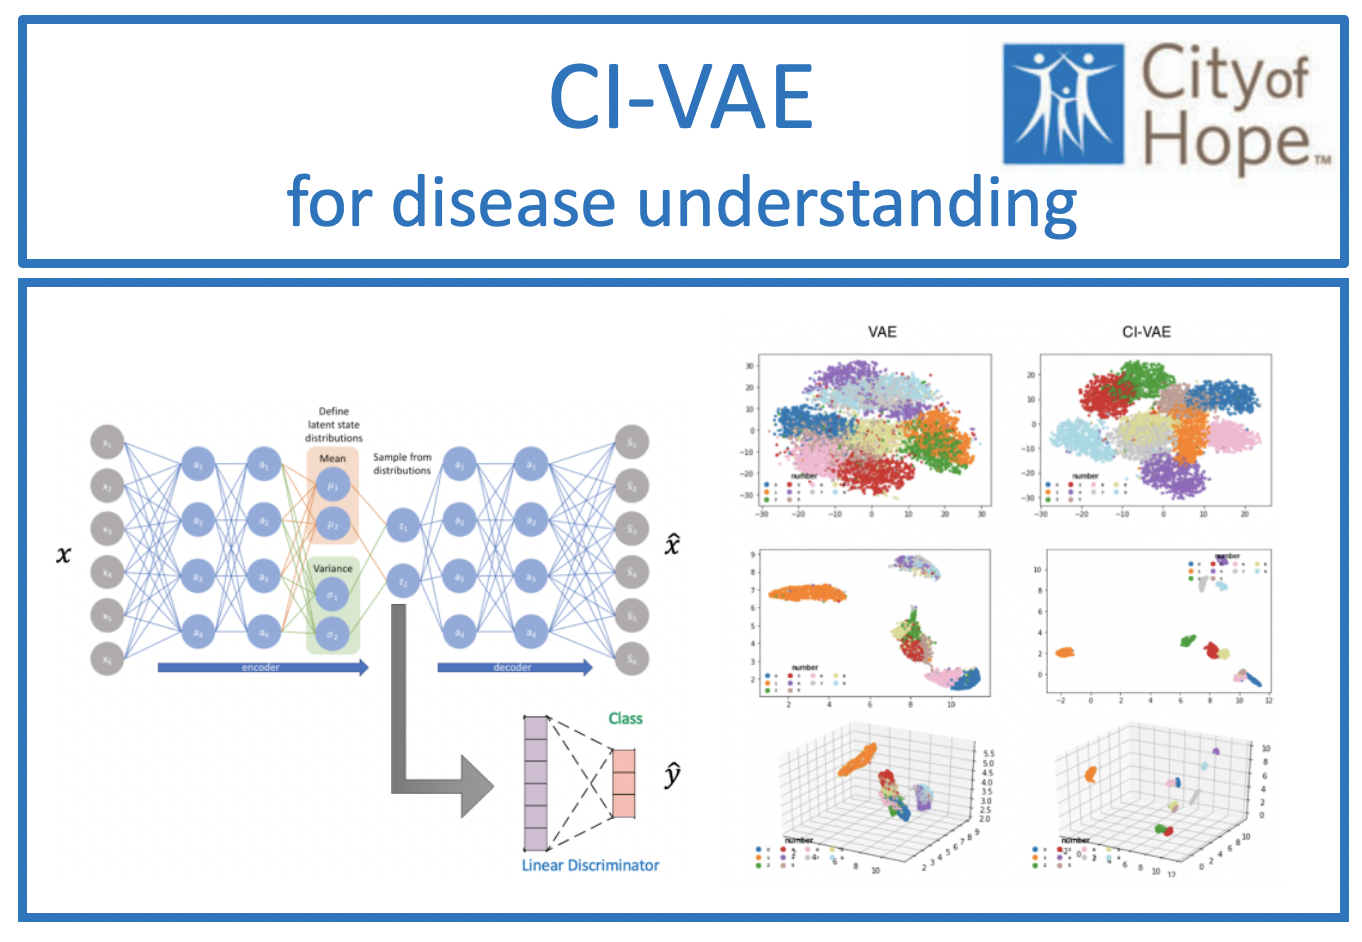
</div>

# Download CI-VAE, other necessary packages and Load Packages

In [22]:
'''
! rm -rf ci_vae
! rm bb.pt
! rm bb_residuals.pkl
! rm df_reconstructed.csv
! rm df_reconstructed_decoder.csv
! rm residuals.pdf
! rm results_dict.pkl
! rm df_latent.csv
'''

rm: cannot remove 'bb.pt': No such file or directory
rm: cannot remove 'bb_residuals.pkl': No such file or directory
rm: cannot remove 'df_reconstructed.csv': No such file or directory
rm: cannot remove 'df_reconstructed_decoder.csv': No such file or directory
rm: cannot remove 'residuals.pdf': No such file or directory
rm: cannot remove 'results_dict.pkl': No such file or directory
rm: cannot remove 'df_latent.csv': No such file or directory


In [23]:
! git clone https://github.com/monabiyan/ci_vae.git

Cloning into 'ci_vae'...
remote: Enumerating objects: 477, done.
remote: Total 477 (delta 0), reused 0 (delta 0), pack-reused 477 (from 1)
Receiving objects: 100% (477/477), 69.52 MiB | 1.06 MiB/s, done.
Resolving deltas: 100% (270/270), done.


In [2]:
'''
!pip install pandas
!pip install scikit-learn
!conda install -y pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
!pip install matplotlib
'''

done
Channels:
 - pytorch
 - nvidia
 - defaults
Platform: linux-64
doneecting package metadata (repodata.json): - 
doneenvironment: 

# All requested packages already installed.



In [20]:
import sys, subprocess, sysconfig, json, pathlib, platform
print("Kernel Python:", sys.executable)

%pip install -U matplotlib pandas scikit-learn xgboost umap-learn

Kernel Python: /home/mnabian/miniconda3/envs/transformers/bin/python
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 128.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt
from ci_vae import ivae

In [22]:
#import umap

In [2]:
!nvidia-smi

Thu Apr 17 14:19:35 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:17:00.0 Off |                    0 |
| N/A   26C    P0              45W / 250W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Generate Input Data

Here we are generating a sample data. 

Alternatively you can load your custom data. But make sure the data is normalized and has to have one column 'Y' representing celltype with numbers {0,1,2,3,...} and 'YY' representing states {0,1} commonly 0 for healthy and 1 for cancer. 

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_csv('/coh_labs/AI_DS/ai_histopath/prov-gigapath/prov-gigapath/mohsen_output/slide_embeddings.csv')

# Convert slide_embedding from string representation of lists to actual lists
df['slide_embedding'] = df['slide_embedding'].apply(eval)

# Extract X matrix and y vector
X = np.array(df['slide_embedding'].tolist())
y = df['label'].tolist()

# Create a DataFrame for X
df_X = pd.DataFrame(X)

# Add y column to the DataFrame
df_X['Y'] = y

# Add 'YY' column with all values set to 0
df_X['YY'] = 0

# Rename columns to avoid ambiguity (if needed)
df_X.columns = [f'X_{i}' for i in range(X.shape[1])] + ['Y', 'YY']

# Store in df_XY
df_XY = df_X

# Split data into training (70%) and test (30%)
df_XY_train, df_XY_test = train_test_split(df_XY, test_size=0.3, random_state=42, shuffle=True)

# Display the shapes of the resulting datasets
print("Train set shape:", df_XY_train.shape)
print("Test set shape:", df_XY_test.shape)

# Display the first few rows of the test set
print(df_XY_test.head())
df_XY = df_XY_train.copy()


Train set shape: (109, 770)
Test set shape: (48, 770)
          X_0       X_1       X_2       X_3       X_4       X_5       X_6  \
126  0.155631 -0.595249  1.274674 -0.975983  0.162853  0.482092  0.748111   
45  -0.040432 -0.521011  1.304167 -1.105633  0.427429  0.290010  0.797926   
133  0.531592 -1.002796  1.196579 -0.744310 -0.014202  0.604555  0.404477   
138  0.026737 -0.653492  1.284624 -1.084687  0.409357  0.386568  0.827423   
111 -0.099016 -0.370136  1.241783 -1.040273  0.352901  0.079692  0.982345   

          X_7       X_8       X_9  ...     X_760     X_761     X_762  \
126  0.932614 -0.685729  0.824572  ...  0.835961  0.619678 -0.279206   
45   0.758010 -0.731060  0.900117  ...  0.781905  0.733725 -0.282767   
133  1.141283 -0.829965  0.739034  ...  1.274826  0.384924 -0.244546   
138  0.816509 -0.726052  0.936095  ...  0.905968  0.755704 -0.234862   
111  0.579371 -0.800136  0.981532  ...  0.941217  0.746667 -0.233358   

        X_763     X_764     X_765     X_766     X_

# Set Necessary Parameters 

In [4]:
model_init=True
model_tobe_trained=True
save_address="bb"
kl_coef = 0.0001
reconst_coef = 2
#classifier_coef = 0.1
classifier_coef = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
print(device)

cuda:0


# Initialize the Model

In [6]:
obj1 = ivae.IVAE(df_XY = df_XY,
               latent_size = 768,
               reconst_coef = reconst_coef,
               kl_coef = kl_coef,
               classifier_coef = classifier_coef,
               test_ratio = 1)

if model_init:
    obj1.model_initialize()

## See The Model Architecture

In [57]:
'''
print(obj1.model)
'''

'\nprint(obj1.model)\n'

## See the Initialized Weights

In [58]:
'''
for param in obj1.model.parameters():
    print(param)
'''

'\nfor param in obj1.model.parameters():\n    print(param)\n'

# RUN for Training

In [7]:
##########
if model_tobe_trained:
    lr=1e-5
    print(lr)
    obj1.model_training(epochs=200,learning_rate=lr)
'''
if model_tobe_trained:
    lr=5e-5
    print(lr)
    obj1.model_training(epochs=1000,learning_rate=lr)
if model_tobe_trained:
    lr=5e-1
    print(lr)
    obj1.model_training(epochs=1000,learning_rate=lr)

    lr=1e-6
    print(lr)
    obj1.model_training(epochs=4000,learning_rate=lr)

    #lr=5e-4
    print(lr)
    #obj.model_training(epochs=70,learning_rate=lr)

    #lr=5e-4
    print(lr)
    #obj.model_training(epochs=200,learning_rate=lr)

    #obj1.model_save(address=save_address+".pt")
    #obj1.save_residuals(address=save_address+'_residuals.pkl')
    #lr=5e-4
    #print(lr)
    #obj1.model_training(epochs=100,learning_rate=lr)

    #lr=5e-4
    print(lr)
    #obj1.model_training(epochs=500,learning_rate=lr)

    #obj1.model_save(address=save_address+".pt")
    #obj1.save_residuals(address=save_address+'_residuals.pkl')

    lr=5e-4
    print(lr)
    obj1.model_training(epochs=500,learning_rate=lr)

    lr=5e-4
    print(lr)
    obj1.model_training(epochs=500,learning_rate=lr)
'''

1e-05
====> Epoch: 1 total_train_loss: 2.453064 Total_test_loss: 1.980655 Total_BCE_test_loss: 1.285752 Total_KLD_test_loss: 0.000012 Total_CEP_test_loss: 0.694892
====> Epoch: 2 total_train_loss: 2.816331 Total_test_loss: 1.985835 Total_BCE_test_loss: 1.290322 Total_KLD_test_loss: 0.000032 Total_CEP_test_loss: 0.695481
====> Epoch: 3 total_train_loss: 2.603886 Total_test_loss: 1.993188 Total_BCE_test_loss: 1.296300 Total_KLD_test_loss: 0.000065 Total_CEP_test_loss: 0.696824


/coh_labs/AI_DS/ai_histopath/ci_vae/ci_vae/example/ci_vae/ivae.py:304: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(torch.reshape(y, (-1,)), dtype=torch.long)
/coh_labs/AI_DS/ai_histopath/ci_vae/ci_vae/example/ci_vae/ivae.py:332: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(torch.reshape(y, (-1,)), dtype=torch.long)


====> Epoch: 4 total_train_loss: 2.661844 Total_test_loss: 2.001899 Total_BCE_test_loss: 1.303626 Total_KLD_test_loss: 0.000108 Total_CEP_test_loss: 0.698165
====> Epoch: 5 total_train_loss: 2.878266 Total_test_loss: 2.012216 Total_BCE_test_loss: 1.312124 Total_KLD_test_loss: 0.000161 Total_CEP_test_loss: 0.699931
====> Epoch: 6 total_train_loss: 2.701978 Total_test_loss: 2.022319 Total_BCE_test_loss: 1.320579 Total_KLD_test_loss: 0.000223 Total_CEP_test_loss: 0.701518
====> Epoch: 7 total_train_loss: 2.651380 Total_test_loss: 2.034130 Total_BCE_test_loss: 1.330503 Total_KLD_test_loss: 0.000294 Total_CEP_test_loss: 0.703332
====> Epoch: 8 total_train_loss: 2.793114 Total_test_loss: 2.046072 Total_BCE_test_loss: 1.341233 Total_KLD_test_loss: 0.000372 Total_CEP_test_loss: 0.704467
====> Epoch: 9 total_train_loss: 2.718085 Total_test_loss: 2.057300 Total_BCE_test_loss: 1.350575 Total_KLD_test_loss: 0.000456 Total_CEP_test_loss: 0.706269
====> Epoch: 10 total_train_loss: 2.540769 Total_tes

'\nif model_tobe_trained:\n    lr=5e-5\n    print(lr)\n    obj1.model_training(epochs=1000,learning_rate=lr)\nif model_tobe_trained:\n    lr=5e-1\n    print(lr)\n    obj1.model_training(epochs=1000,learning_rate=lr)\n\n    lr=1e-6\n    print(lr)\n    obj1.model_training(epochs=4000,learning_rate=lr)\n\n    #lr=5e-4\n    print(lr)\n    #obj.model_training(epochs=70,learning_rate=lr)\n\n    #lr=5e-4\n    print(lr)\n    #obj.model_training(epochs=200,learning_rate=lr)\n\n    #obj1.model_save(address=save_address+".pt")\n    #obj1.save_residuals(address=save_address+\'_residuals.pkl\')\n    #lr=5e-4\n    #print(lr)\n    #obj1.model_training(epochs=100,learning_rate=lr)\n\n    #lr=5e-4\n    print(lr)\n    #obj1.model_training(epochs=500,learning_rate=lr)\n\n    #obj1.model_save(address=save_address+".pt")\n    #obj1.save_residuals(address=save_address+\'_residuals.pkl\')\n\n    lr=5e-4\n    print(lr)\n    obj1.model_training(epochs=500,learning_rate=lr)\n\n    lr=5e-4\n    print(lr)\n    ob

# Save The Trained Model

In [8]:
##########
print("running the neural network")
#run(obj1,save_address)
obj1.model_save(address=save_address+".pt")
obj1.save_residuals(address=save_address+'_residuals.pkl')

running the neural network


# Visualize Residuals

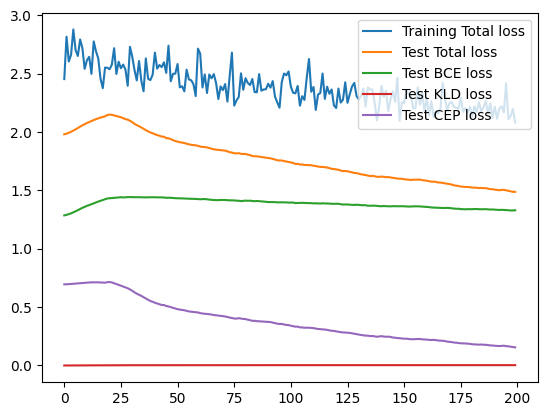

<Figure size 640x480 with 0 Axes>

In [9]:
obj1.plot_residuals(init_index=0)

# ==================================================

# Test 

# Load Model and Data

In [10]:
from ci_vae import ivae
import pandas as pd
import numpy as np
import sklearn
import torch
#import umap
import pickle
import matplotlib.pyplot as plt

In [11]:
print("start of the code")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##############################################################   
##############################################################
model_init=True
model_tobe_trained=False

model_init=True
model_file_address='./bb.pt'
save_address1="./"

#df_XY=pd.read_csv('df_XY.csv')
#df_XY.head(n=10)

start of the code


## Load Saved Model

In [12]:
obj2 = ivae.IVAE(df_XY = df_XY,
               reconst_coef = reconst_coef,
               latent_size = 768,
               kl_coef = kl_coef,
               classifier_coef = classifier_coef,
               test_ratio = 1)

obj2.model_initialize()

obj2.model_load(address="bb.pt")

/coh_labs/AI_DS/ai_histopath/ci_vae/ci_vae/example/ci_vae/ivae.py:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(address))


In [13]:
obj2.df_XY

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_759,X_760,X_761,X_762,X_763,X_764,X_765,X_766,X_767,Y
140,-0.019773,-0.390524,1.289476,-1.147143,0.437500,0.274089,0.868927,0.668827,-0.606214,0.909801,...,0.870101,0.515434,0.803776,-0.268816,-0.301228,-0.411815,2.405220,-0.376958,-0.880242,0.0
11,-0.064023,-0.516262,1.276855,-1.040890,0.377382,0.213849,0.843713,0.666060,-0.747183,0.917049,...,0.823801,0.826157,0.719550,-0.242252,-0.209503,-0.254126,2.162409,-0.249148,-0.883211,0.0
79,0.603263,-0.979649,1.146391,-0.859893,-0.117140,0.525901,0.619139,1.126983,-0.830745,0.784961,...,0.714733,1.434390,0.281162,-0.349329,-0.224856,-0.166597,1.636468,0.363881,0.072359,0.0
68,-0.028581,-0.591174,1.253315,-1.028038,0.318666,0.406958,0.738455,0.771714,-0.753828,0.856991,...,0.840113,0.880085,0.725959,-0.169418,-0.223456,-0.329962,2.238216,-0.325114,-0.755474,0.0
149,-0.159147,-0.231083,1.227010,-1.183055,0.429463,0.076368,0.841081,0.622103,-0.684036,0.907696,...,0.907699,0.590739,0.805038,-0.250515,-0.247009,-0.353487,2.411108,-0.409685,-1.043920,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,-0.026130,-0.661248,1.314106,-0.988825,0.234990,0.352278,0.796119,0.725484,-0.879284,0.875786,...,0.864361,1.063194,0.783830,-0.279424,-0.260332,-0.215041,2.131716,-0.208368,-0.817985,1.0
106,-0.076122,-0.503591,1.325479,-1.073128,0.350227,0.254231,0.823979,0.576522,-0.683636,0.937192,...,0.850958,0.868615,0.770098,-0.321364,-0.212239,-0.209920,2.193252,-0.299118,-0.764975,0.0
14,-0.057477,-0.536049,1.384260,-1.101498,0.438072,0.163497,0.858966,0.655345,-0.843301,0.886547,...,0.859278,0.943829,0.806684,-0.213438,-0.302313,-0.216594,2.218406,-0.288340,-0.785919,0.0
92,1.027837,-0.830313,0.994056,-0.875594,-0.235434,0.626301,0.286453,1.406734,-0.569401,0.677197,...,0.601509,1.202664,0.097442,-0.359115,-0.056748,-0.337858,1.585848,0.320483,0.354676,0.0


## Print the Weights

In [34]:
'''
for param in obj2.model.parameters():
    print(param)
'''

'\nfor param in obj2.model.parameters():\n    print(param)\n'

# Make Prediction of All Test Data

In [14]:
with torch.no_grad():
    obj2.model.eval()

    obj2.load_residuals(address='bb_residuals.pkl')
    print("model loaded")
    
    obj2.generate_test_results()
    print("test data generated")

model loaded
test data generated


/coh_labs/AI_DS/ai_histopath/ci_vae/ci_vae/example/ci_vae/ivae.py:332: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(torch.reshape(y, (-1,)), dtype=torch.long)


# Comprehensive Checking of The Prediction Values vs. True Values. 

In [15]:

print(obj2.x_last)


tensor([[-0.0198, -0.3905,  1.2895,  ...,  2.4052, -0.3770, -0.8802],
        [-0.0640, -0.5163,  1.2769,  ...,  2.1624, -0.2491, -0.8832],
        [ 0.6033, -0.9796,  1.1464,  ...,  1.6365,  0.3639,  0.0724],
        ...,
        [-0.0575, -0.5360,  1.3843,  ...,  2.2184, -0.2883, -0.7859],
        [ 1.0278, -0.8303,  0.9941,  ...,  1.5858,  0.3205,  0.3547],
        [ 1.1258, -0.7509,  0.8183,  ...,  1.4777,  0.3497,  0.5611]],
       device='cuda:0')


In [16]:

print(obj2.x_pred)


tensor([[-0.6222, -0.5257, -0.0793,  ...,  0.6223,  0.1072,  0.1936],
        [-0.6960, -0.3424, -0.0215,  ...,  0.5208, -0.5851, -0.0292],
        [-0.3827, -0.4655, -0.0166,  ...,  0.4081, -0.1701, -0.4949],
        ...,
        [-0.1778, -0.2541, -0.0621,  ...,  0.1671,  0.1264,  0.1430],
        [-0.7409, -0.2451,  0.3720,  ..., -0.0684,  0.0212,  0.2975],
        [-0.4905,  0.2227,  0.6626,  ...,  0.4514,  0.3755,  0.3712]],
       device='cuda:0')


In [38]:

'''(np.abs(obj2.x_pred - obj2.x_last)).mean()'''


'(np.abs(obj2.x_pred - obj2.x_last)).mean()'

In [17]:

(obj2.x_pred-obj2.x_last)


tensor([[-0.6024, -0.1352, -1.3688,  ..., -1.7830,  0.4842,  1.0739],
        [-0.6320,  0.1738, -1.2983,  ..., -1.6416, -0.3360,  0.8541],
        [-0.9859,  0.5141, -1.1630,  ..., -1.2283, -0.5340, -0.5673],
        ...,
        [-0.1204,  0.2820, -1.4463,  ..., -2.0514,  0.4148,  0.9290],
        [-1.7688,  0.5852, -0.6221,  ..., -1.6542, -0.2993, -0.0572],
        [-1.6163,  0.9736, -0.1557,  ..., -1.0262,  0.0258, -0.1899]],
       device='cuda:0')

In [40]:
'''
print(obj2.y_last)
'''

'\nprint(obj2.y_last)\n'

In [41]:
'''
print(obj2.y_pred)
'''

'\nprint(obj2.y_pred)\n'

In [18]:
with torch.no_grad():
    obj2.model.eval()
    for x, y in obj2.testloader:
      x = x.to(device)
      # forward
      x_hat,y_hat, mu, logvar,z = obj2.model(x)
    
    df_reconstructed = pd.DataFrame(x_hat.cpu().detach().numpy(), columns=obj2.df_XY.drop(columns=['Y']).columns)
    print(df_reconstructed.shape)
    df_latent=pd.DataFrame(z.cpu().detach().numpy())
    
    obj2.model.eval()
    
    df_reconstructed_decoder=pd.DataFrame(obj2.model.decoder(z).cpu().detach().numpy(), columns=obj2.df_XY.drop(columns=['Y']).columns)

    df_reconstructed.to_csv('df_reconstructed.csv')
    df_latent.to_csv('df_latent.csv')
    df_reconstructed_decoder.to_csv('df_reconstructed_decoder.csv')
    print("Full_data_reconstructed...")
    '''
    print("========df_reconstructed========")
    print(df_reconstructed)
    print("========df_reconstructed_decoder========")
    print(df_reconstructed_decoder)
    print("========df_Original========")
    print(df_XY)
     '''
    
    


(109, 768)
Full_data_reconstructed...


# Checking Linear Separability of Data on Lower Dimensioanl Space

In [19]:
print("regression analysis")
obj2.regression_analysis(obj2.zs,df_XY['Y'])

regression analysis
1.0


# Visualize Data on Lower Dimensional Space

In [76]:
! pip install umap-learn

calculate tsne_umap_pca


/home/mnabian/miniconda3/envs/transformers/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mnabian/miniconda3/envs/transformers/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mnabian/miniconda3/envs/transformers/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


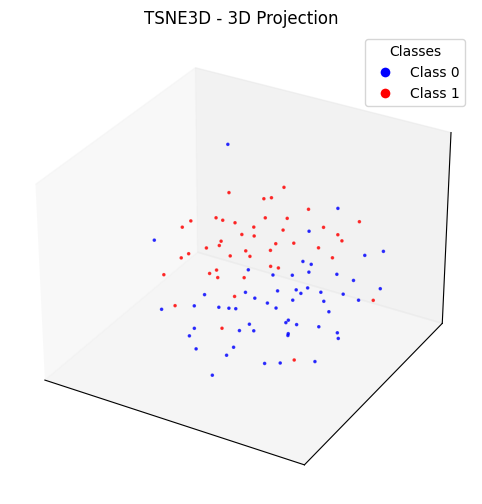

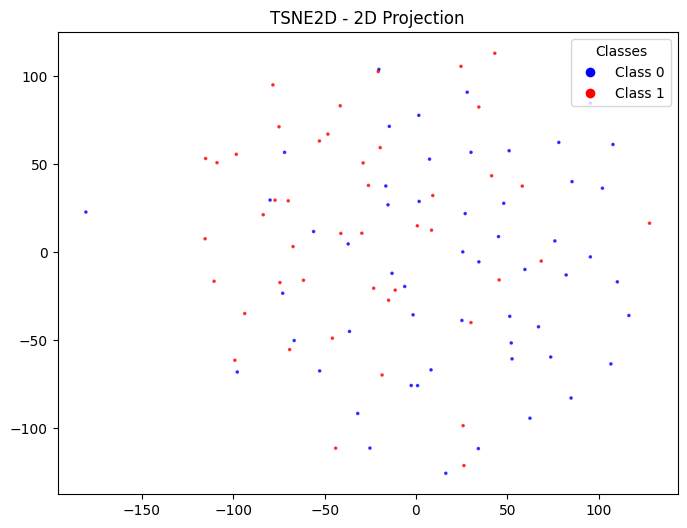

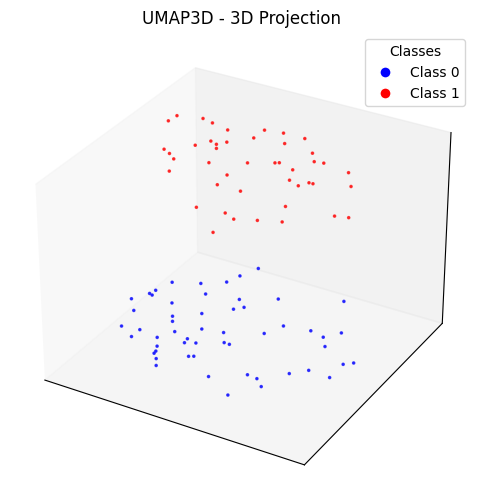

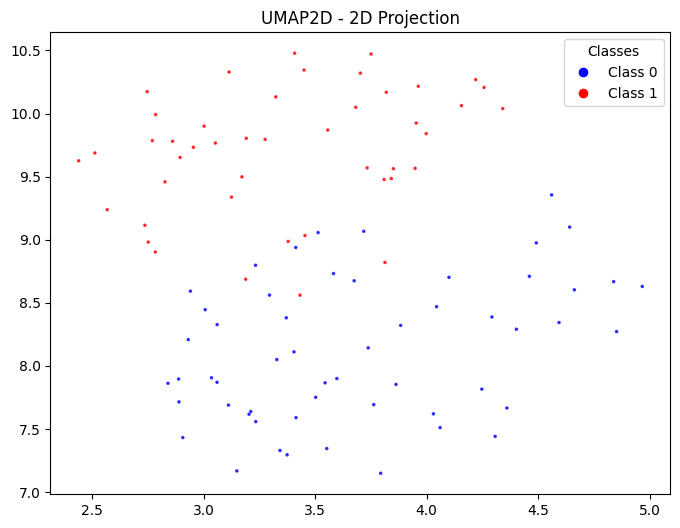

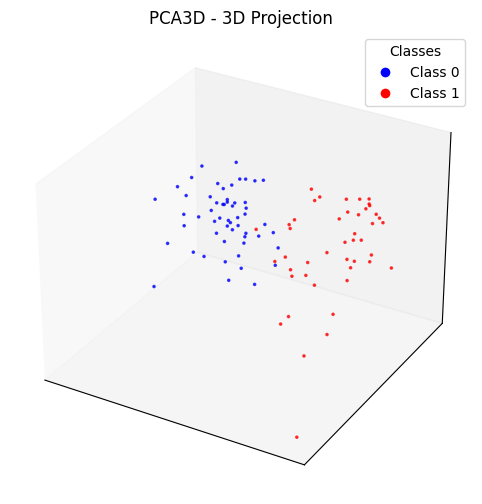

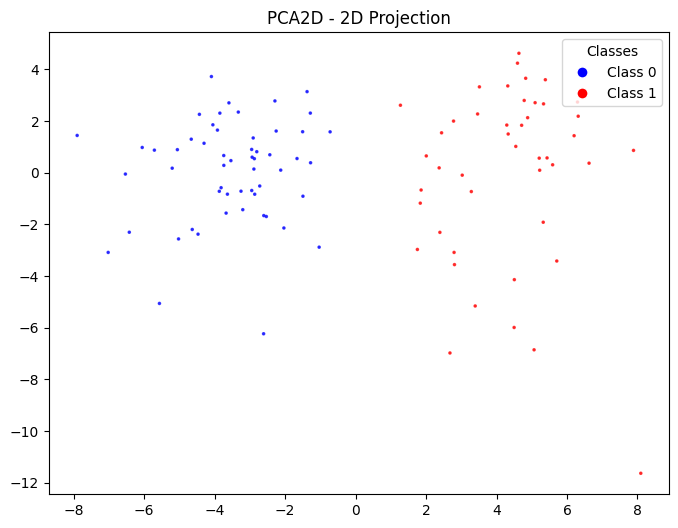

finished


In [20]:
print("calculate tsne_umap_pca")
tsne_mat, umap_mat, pca_mat, Y = obj2.calculate_lower_dimensions(obj2.zs, obj2.y_last, N=100)

obj2.plot_lower_dimension(tsne_mat, Y, projection='3d', save_str='tsne3d.pdf')
obj2.plot_lower_dimension(tsne_mat, Y, projection='2d', save_str='tsne2d.pdf')
obj2.plot_lower_dimension(umap_mat, Y, projection='3d', save_str='umap3d.pdf')
obj2.plot_lower_dimension(umap_mat, Y, projection='2d', save_str='umap2d.pdf')
obj2.plot_lower_dimension(pca_mat, Y, projection='3d', save_str='pca3d.pdf')
obj2.plot_lower_dimension(pca_mat, Y, projection='2d', save_str='pca2d.pdf')

print("finished")



# Generate Synthetic Data for a Given Class

In [96]:
synt_data_0 = obj2.synthetic_single_group(group_id=0,nr_of_synthetic=2000)
print(synt_data_0.shape)

59 59
(2000, 768)


In [79]:
synt_data_0

array([[-0.01093957, -0.58438593,  1.3191278 , ...,  2.25865436,
        -0.19374639, -0.84030443],
       [-0.01096415, -0.58420372,  1.3191098 , ...,  2.25862432,
        -0.19373998, -0.8402527 ],
       [-0.01099716, -0.58401579,  1.31909704, ...,  2.25858808,
        -0.19373918, -0.84021276],
       ...,
       [ 0.97288531, -0.82082969,  0.98594356, ...,  1.56525362,
         0.32280356,  0.37952003],
       [ 0.97290921, -0.8205983 ,  0.98555839, ...,  1.56571138,
         0.323053  ,  0.37971178],
       [ 0.97293401, -0.82042485,  0.98524237, ...,  1.56620097,
         0.3232432 ,  0.37992519]])

In [97]:
synt_data_1 = obj2.synthetic_single_group(group_id=1,nr_of_synthetic=2000)
print(synt_data_1.shape)

50 50
(2000, 768)


In [81]:
synt_data_1

array([[-0.07347422, -0.39839029,  1.26380837, ...,  2.29190278,
        -0.34169462, -0.85242897],
       [-0.07367839, -0.39914912,  1.26408577, ...,  2.29193473,
        -0.34137213, -0.85282296],
       [-0.0738873 , -0.39993483,  1.26439989, ...,  2.29196   ,
        -0.34101856, -0.8532297 ],
       ...,
       [ 0.02054458, -0.52632278,  1.28026068, ...,  2.25819707,
        -0.20090041, -0.7144689 ],
       [ 0.02042036, -0.52641451,  1.28024423, ...,  2.2581594 ,
        -0.20091611, -0.71466547],
       [ 0.02027484, -0.52647287,  1.28023338, ...,  2.25816011,
        -0.20095676, -0.71490616]])

In [90]:
 df_XY

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_760,X_761,X_762,X_763,X_764,X_765,X_766,X_767,Y,YY
140,-0.019773,-0.390524,1.289476,-1.147143,0.437500,0.274089,0.868927,0.668827,-0.606214,0.909801,...,0.515434,0.803776,-0.268816,-0.301228,-0.411815,2.405220,-0.376958,-0.880242,0.0,0
11,-0.064023,-0.516262,1.276855,-1.040890,0.377382,0.213849,0.843713,0.666060,-0.747183,0.917049,...,0.826157,0.719550,-0.242252,-0.209503,-0.254126,2.162409,-0.249148,-0.883211,0.0,0
79,0.603263,-0.979649,1.146391,-0.859893,-0.117140,0.525901,0.619139,1.126983,-0.830745,0.784961,...,1.434390,0.281162,-0.349329,-0.224856,-0.166597,1.636468,0.363881,0.072359,0.0,0
68,-0.028581,-0.591174,1.253315,-1.028038,0.318666,0.406958,0.738455,0.771714,-0.753828,0.856991,...,0.880085,0.725959,-0.169418,-0.223456,-0.329962,2.238216,-0.325114,-0.755474,0.0,0
149,-0.159147,-0.231083,1.227010,-1.183055,0.429463,0.076368,0.841081,0.622103,-0.684036,0.907696,...,0.590739,0.805038,-0.250515,-0.247009,-0.353487,2.411108,-0.409685,-1.043920,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,-0.026130,-0.661248,1.314106,-0.988825,0.234990,0.352278,0.796119,0.725484,-0.879284,0.875786,...,1.063194,0.783830,-0.279424,-0.260332,-0.215041,2.131716,-0.208368,-0.817985,1.0,0
106,-0.076122,-0.503591,1.325479,-1.073128,0.350227,0.254231,0.823979,0.576522,-0.683636,0.937192,...,0.868615,0.770098,-0.321364,-0.212239,-0.209920,2.193252,-0.299118,-0.764975,0.0,0
14,-0.057477,-0.536049,1.384260,-1.101498,0.438072,0.163497,0.858966,0.655345,-0.843301,0.886547,...,0.943829,0.806684,-0.213438,-0.302313,-0.216594,2.218406,-0.288340,-0.785919,0.0,0
92,1.027837,-0.830313,0.994056,-0.875594,-0.235434,0.626301,0.286453,1.406734,-0.569401,0.677197,...,1.202664,0.097442,-0.359115,-0.056748,-0.337858,1.585848,0.320483,0.354676,0.0,0


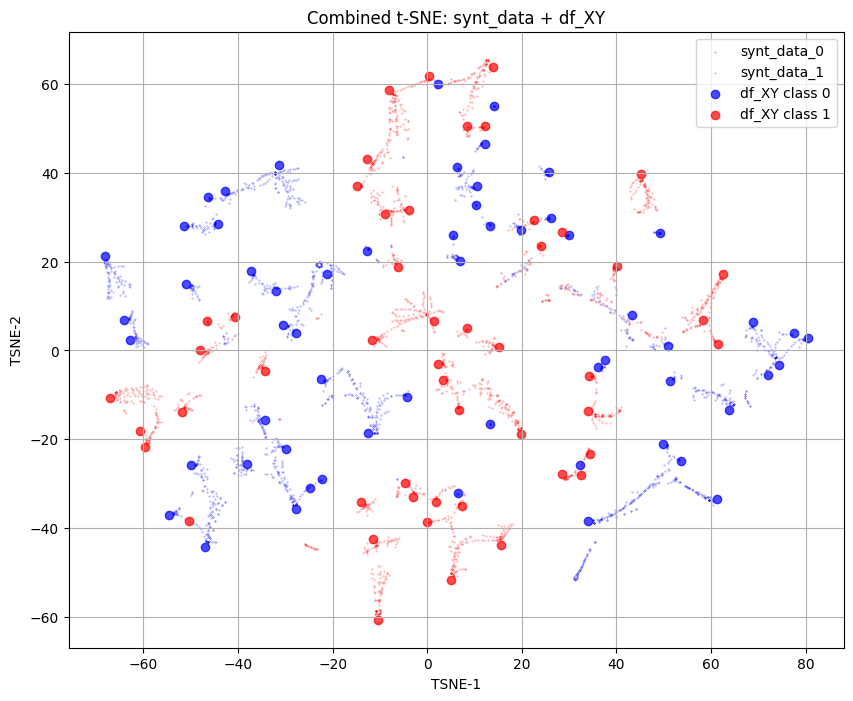

In [98]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Prepare synthetic data
bx = np.vstack([synt_data_0, synt_data_1])
by = np.array([0] * len(synt_data_0) + [1] * len(synt_data_1))

# Prepare df_XY data
xb = df_XY.drop(columns=['Y', 'YY']).values
yb = df_XY['Y'].values

# Combine all data
X_all = np.vstack([bx, xb])
y_all = np.concatenate([by, yb + 2])  # shift df_XY labels to avoid confusion with 0 and 1

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_all)

# Indices for each group
n_bx = len(bx)
n_df = len(xb)
bx_idx = np.arange(n_bx)
xb_idx = np.arange(n_bx, n_bx + n_df)

# Plot
plt.figure(figsize=(10, 8))

# Plot synthetic data (tiny dots)
plt.scatter(X_embedded[bx_idx][by == 0, 0], X_embedded[bx_idx][by == 0, 1], 
            c='blue', label='synt_data_0', alpha=0.5, s=0.1)
plt.scatter(X_embedded[bx_idx][by == 1, 0], X_embedded[bx_idx][by == 1, 1], 
            c='red', label='synt_data_1', alpha=0.5, s=0.1)

# Plot df_XY data (regular size)
plt.scatter(X_embedded[xb_idx][yb == 0, 0], X_embedded[xb_idx][yb == 0, 1], 
            c='blue', label='df_XY class 0', alpha=0.7)
plt.scatter(X_embedded[xb_idx][yb == 1, 0], X_embedded[xb_idx][yb == 1, 1], 
            c='red', label='df_XY class 1', alpha=0.7)

plt.legend()
plt.title("Combined t-SNE: synt_data + df_XY")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.grid(True)
plt.show()


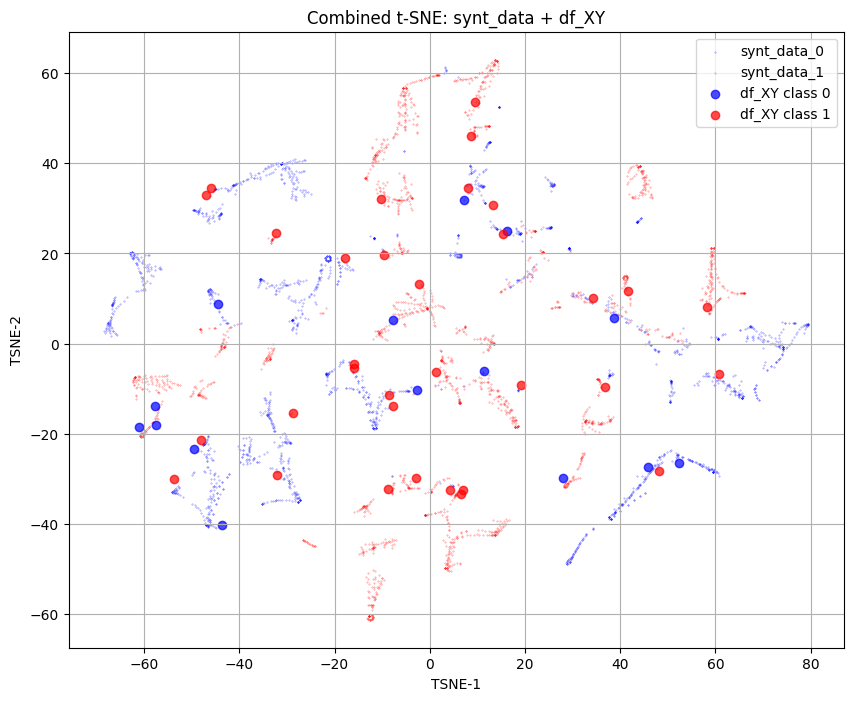

In [99]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Prepare synthetic data
bx = np.vstack([synt_data_0, synt_data_1])
by = np.array([0] * len(synt_data_0) + [1] * len(synt_data_1))

# Prepare df_XY data
xb = df_XY_test.drop(columns=['Y', 'YY']).values
yb = df_XY_test['Y'].values

# Combine all data
X_all = np.vstack([bx, xb])
y_all = np.concatenate([by, yb + 2])  # shift df_XY labels to avoid confusion with 0 and 1

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_all)

# Indices for each group
n_bx = len(bx)
n_df = len(xb)
bx_idx = np.arange(n_bx)
xb_idx = np.arange(n_bx, n_bx + n_df)

# Plot
plt.figure(figsize=(10, 8))

# Plot synthetic data (tiny dots)
plt.scatter(X_embedded[bx_idx][by == 0, 0], X_embedded[bx_idx][by == 0, 1], 
            c='blue', label='synt_data_0', alpha=0.5, s=0.1)
plt.scatter(X_embedded[bx_idx][by == 1, 0], X_embedded[bx_idx][by == 1, 1], 
            c='red', label='synt_data_1', alpha=0.5, s=0.1)

# Plot df_XY data (regular size)
plt.scatter(X_embedded[xb_idx][yb == 0, 0], X_embedded[xb_idx][yb == 0, 1], 
            c='blue', label='df_XY class 0', alpha=0.7)
plt.scatter(X_embedded[xb_idx][yb == 1, 0], X_embedded[xb_idx][yb == 1, 1], 
            c='red', label='df_XY class 1', alpha=0.7)

plt.legend()
plt.title("Combined t-SNE: synt_data + df_XY")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.grid(True)
plt.show()


In [82]:
import pandas as pd
import numpy as np

# Assuming synt_data_0 and synt_data_1 are numpy arrays with shape (1000, 768)
# Convert them to DataFrames
df_synt_0 = pd.DataFrame(synt_data_0)
df_synt_1 = pd.DataFrame(synt_data_1)

# Add the Y column: 0 for class 0, 1 for class 1
df_synt_0['Y'] = 0
df_synt_1['Y'] = 1

# Add 'YY' column with all values set to 0
df_synt_0['YY'] = 0
df_synt_1['YY'] = 0

# Rename columns to match df_XY format
df_synt_0.columns = [f'X_{i}' for i in range(synt_data_0.shape[1])] + ['Y', 'YY']
df_synt_1.columns = [f'X_{i}' for i in range(synt_data_1.shape[1])] + ['Y', 'YY']

# Concatenate with df_XY
df_XY_train_extended = pd.concat([df_XY, df_synt_0, df_synt_1], ignore_index=True)

# Display the shape to verify
print("Original df_XY shape:", df_XY.shape)
print("Extended df_XY shape:", df_XY_train_extended.shape)

# Display the first few rows of the new DataFrame
print(df_XY_train_extended.head())

Original df_XY shape: (109, 770)
Extended df_XY shape: (20109, 770)
        X_0       X_1       X_2       X_3       X_4       X_5       X_6  \
0 -0.019773 -0.390524  1.289476 -1.147143  0.437500  0.274089  0.868927   
1 -0.064023 -0.516262  1.276855 -1.040890  0.377382  0.213849  0.843713   
2  0.603263 -0.979649  1.146391 -0.859893 -0.117140  0.525901  0.619139   
3 -0.028581 -0.591174  1.253315 -1.028038  0.318666  0.406958  0.738455   
4 -0.159147 -0.231083  1.227010 -1.183055  0.429463  0.076368  0.841081   

        X_7       X_8       X_9  ...     X_760     X_761     X_762     X_763  \
0  0.668827 -0.606214  0.909801  ...  0.515434  0.803776 -0.268816 -0.301228   
1  0.666060 -0.747183  0.917049  ...  0.826157  0.719550 -0.242252 -0.209503   
2  1.126983 -0.830745  0.784961  ...  1.434390  0.281162 -0.349329 -0.224856   
3  0.771714 -0.753828  0.856991  ...  0.880085  0.725959 -0.169418 -0.223456   
4  0.622103 -0.684036  0.907696  ...  0.590739  0.805038 -0.250515 -0.247009   



In [33]:
!pip install -U xgboost


In [83]:
df_XY_test

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_760,X_761,X_762,X_763,X_764,X_765,X_766,X_767,Y,YY
126,0.155631,-0.595249,1.274674,-0.975983,0.162853,0.482092,0.748111,0.932614,-0.685729,0.824572,...,0.835961,0.619678,-0.279206,-0.192166,-0.264794,2.178134,-0.147545,-0.713128,1.0,0
45,-0.040432,-0.521011,1.304167,-1.105633,0.427429,0.290010,0.797926,0.758010,-0.731060,0.900117,...,0.781905,0.733725,-0.282767,-0.263509,-0.310490,2.308538,-0.287282,-0.803158,1.0,0
133,0.531592,-1.002796,1.196579,-0.744310,-0.014202,0.604555,0.404477,1.141283,-0.829965,0.739034,...,1.274826,0.384924,-0.244546,-0.141884,-0.282083,1.727646,0.163236,-0.134642,1.0,0
138,0.026737,-0.653492,1.284624,-1.084687,0.409357,0.386568,0.827423,0.816509,-0.726052,0.936095,...,0.905968,0.755704,-0.234862,-0.279939,-0.275886,2.322573,-0.162263,-0.724740,0.0,0
111,-0.099016,-0.370136,1.241783,-1.040273,0.352901,0.079692,0.982345,0.579371,-0.800136,0.981532,...,0.941217,0.746667,-0.233358,-0.155640,-0.221325,2.258160,-0.407387,-0.916141,1.0,0
29,1.225006,-0.781793,0.692865,-0.784175,-0.168925,0.157520,0.279194,1.504063,-0.416410,0.577289,...,1.316859,0.028890,-0.166459,-0.094418,-0.615114,1.680795,0.339341,0.541358,0.0,0
95,-0.032375,-0.540896,1.289657,-1.089949,0.449064,0.322612,0.831388,0.731818,-0.710068,0.919668,...,0.789574,0.832244,-0.294922,-0.279491,-0.288046,2.294055,-0.260753,-0.843626,0.0,0
97,-0.173355,-0.339008,1.290965,-1.068646,0.437579,0.187284,0.884419,0.677650,-0.779934,0.943760,...,0.642150,0.864712,-0.249713,-0.193086,-0.297337,2.365921,-0.451538,-1.083059,1.0,0
94,1.046770,-0.794528,0.940323,-0.726896,-0.117634,0.424400,0.355642,1.563089,-0.658692,0.629709,...,1.444928,0.144589,-0.282423,-0.059781,-0.293141,1.524343,0.370550,0.478509,1.0,0
139,-0.019525,-0.499129,1.320023,-1.119493,0.423223,0.249429,0.823258,0.659412,-0.683526,0.908533,...,0.681068,0.786016,-0.292995,-0.288400,-0.355386,2.341699,-0.262835,-0.845932,1.0,0


In [50]:
df_XY

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_760,X_761,X_762,X_763,X_764,X_765,X_766,X_767,Y,YY
140,-0.019773,-0.390524,1.289476,-1.147143,0.437500,0.274089,0.868927,0.668827,-0.606214,0.909801,...,0.515434,0.803776,-0.268816,-0.301228,-0.411815,2.405220,-0.376958,-0.880242,0.0,0
11,-0.064023,-0.516262,1.276855,-1.040890,0.377382,0.213849,0.843713,0.666060,-0.747183,0.917049,...,0.826157,0.719550,-0.242252,-0.209503,-0.254126,2.162409,-0.249148,-0.883211,0.0,0
79,0.603263,-0.979649,1.146391,-0.859893,-0.117140,0.525901,0.619139,1.126983,-0.830745,0.784961,...,1.434390,0.281162,-0.349329,-0.224856,-0.166597,1.636468,0.363881,0.072359,0.0,0
68,-0.028581,-0.591174,1.253315,-1.028038,0.318666,0.406958,0.738455,0.771714,-0.753828,0.856991,...,0.880085,0.725959,-0.169418,-0.223456,-0.329962,2.238216,-0.325114,-0.755474,0.0,0
149,-0.159147,-0.231083,1.227010,-1.183055,0.429463,0.076368,0.841081,0.622103,-0.684036,0.907696,...,0.590739,0.805038,-0.250515,-0.247009,-0.353487,2.411108,-0.409685,-1.043920,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,-0.026130,-0.661248,1.314106,-0.988825,0.234990,0.352278,0.796119,0.725484,-0.879284,0.875786,...,1.063194,0.783830,-0.279424,-0.260332,-0.215041,2.131716,-0.208368,-0.817985,1.0,0
106,-0.076122,-0.503591,1.325479,-1.073128,0.350227,0.254231,0.823979,0.576522,-0.683636,0.937192,...,0.868615,0.770098,-0.321364,-0.212239,-0.209920,2.193252,-0.299118,-0.764975,0.0,0
14,-0.057477,-0.536049,1.384260,-1.101498,0.438072,0.163497,0.858966,0.655345,-0.843301,0.886547,...,0.943829,0.806684,-0.213438,-0.302313,-0.216594,2.218406,-0.288340,-0.785919,0.0,0
92,1.027837,-0.830313,0.994056,-0.875594,-0.235434,0.626301,0.286453,1.406734,-0.569401,0.677197,...,1.202664,0.097442,-0.359115,-0.056748,-0.337858,1.585848,0.320483,0.354676,0.0,0


/home/mnabian/miniconda3/envs/transformers/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:18:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC Score: 0.6303


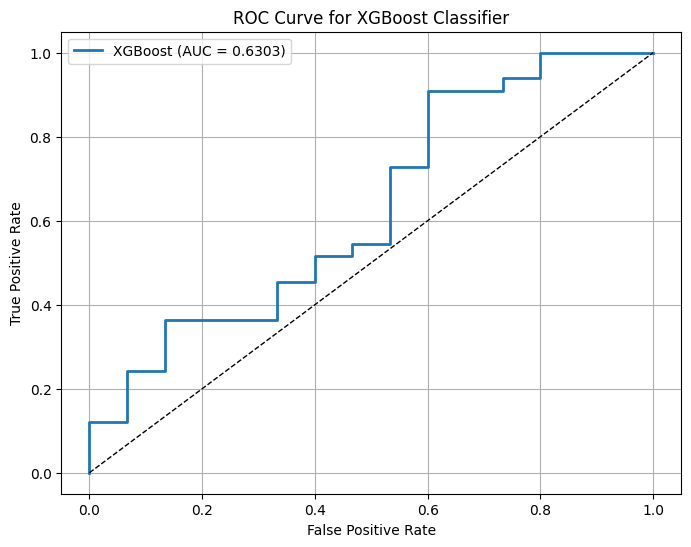

     True_Label  Predicted_Probability  Predicted_Label
126         1.0               0.999926                1
45          1.0               0.083092                0
133         1.0               0.102080                0
138         0.0               0.368398                0
111         1.0               0.156256                0
29          0.0               0.178575                0
95          0.0               0.963449                1
97          1.0               0.524840                1
94          1.0               0.390744                0
139         1.0               0.378149                0
19          1.0               0.959821                1
56          1.0               0.698757                1
15          1.0               0.993170                1
69          1.0               0.136470                0
24          1.0               0.012275                0
30          0.0               0.009526                0
125         0.0               0.735858          

In [100]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Extract features (X) and labels (Y) for training and testing sets
X_train = df_XY_train_extended.drop(columns=['Y', 'YY'])
y_train = df_XY_train_extended['Y']

X_test = df_XY_test.drop(columns=['Y', 'YY'])
y_test = df_XY_test['Y']

# Train XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_prob = xgb_clf.predict_proba(X_test)[:, 1]  # Get probability for class 1
y_pred = xgb_clf.predict(X_test)  # Get binary predictions

# Calculate AUC
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc_score:.4f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Classifier')
plt.legend()
plt.grid()
plt.show()

# Create a DataFrame for predictions vs true labels
df_predictions = pd.DataFrame({'True_Label': y_test, 'Predicted_Probability': y_prob, 'Predicted_Label': y_pred})

print(df_predictions)


In [101]:
obj2.plot_lower_dimension()

TypeError: plot_lower_dimension() missing 2 required positional arguments: 'EE' and 'Y'